In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from datetime import timedelta, datetime
from time import time

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [5]:
df_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [6]:
df_ice_cream.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [7]:
df_ice_cream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       577 non-null    datetime64[ns]
 1   IPN31152N  577 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.1 KB


In [8]:
df_ice_cream = df_ice_cream.rename(columns={'IPN31152N':'production', 'DATE':'Date'})
df_ice_cream = df_ice_cream.set_index('Date')
df_ice_cream.head()

,production
Date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [9]:
df_production = df_ice_cream['production']
df_production.head()

Date
1972-01-01    59.9622
1972-02-01    67.0605
1972-03-01    74.2350
1972-04-01    78.1120
1972-05-01    84.7636
Name: production, dtype: float64

In [10]:
#infer the frequency of the data
df_production = df_production.asfreq(pd.infer_freq(df_production.index))
df_production

Date
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 577, dtype: float64

In [11]:
start_date = datetime(2010,1,1)
production_from_2010 = df_production[start_date:]
production_from_2010.head()

Date
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
Freq: MS, Name: production, dtype: float64

In [12]:
production_from_2010.tail()

Date
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, dtype: float64

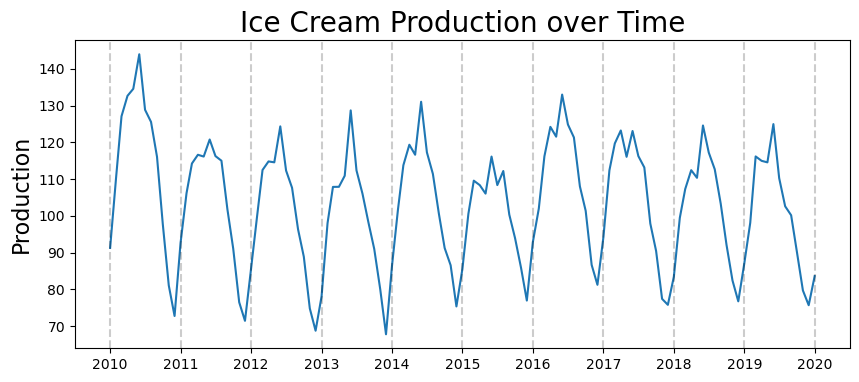

In [13]:
plt.figure(figsize=(10,4))
plt.plot(production_from_2010)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)

for year in range(2010,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

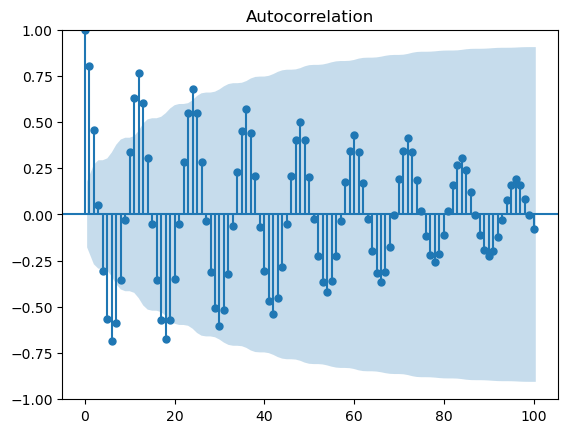

In [14]:
acf_plot = plot_acf(production_from_2010, lags=100)

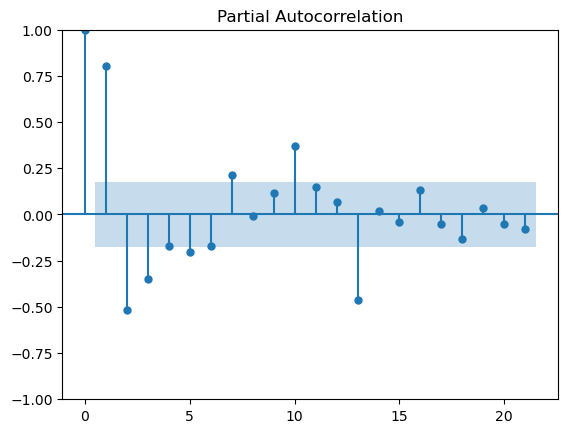

In [15]:
pacf_plot = plot_pacf(production_from_2010, method='ywm')

Based on PACF, we should start with an Autoregressive model with lags 1, 2, 3 (also: 10, 13)

In [16]:
# get train and test sets
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

train_data = production_from_2010[:train_end]
test_data = production_from_2010[train_end + timedelta(days=1):test_end]

In [17]:
print(train_data.size)
print(test_data.size)

108
12


In [18]:
train_data

Date
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
                ...   
2018-08-01    112.6779
2018-09-01    103.3118
2018-10-01     92.1321
2018-11-01     82.4347
2018-12-01     76.7608
Freq: MS, Name: production, Length: 108, dtype: float64

In [19]:
test_data

Date
2019-01-01     86.9988
2019-02-01     98.1116
2019-03-01    116.1718
2019-04-01    114.9703
2019-05-01    114.5613
2019-06-01    124.9605
2019-07-01    110.2632
2019-08-01    102.6085
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
Freq: MS, Name: production, dtype: float64

# Fit the AR model

In [26]:
# create the model with lag 3 and MA 0
model = ARIMA(train_data, order=(3,0,0))

In [27]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 9.931021213531494


In [28]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Sat, 04 Feb 2023   AIC                            758.170
Time:                        19:47:31   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

In [29]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [30]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

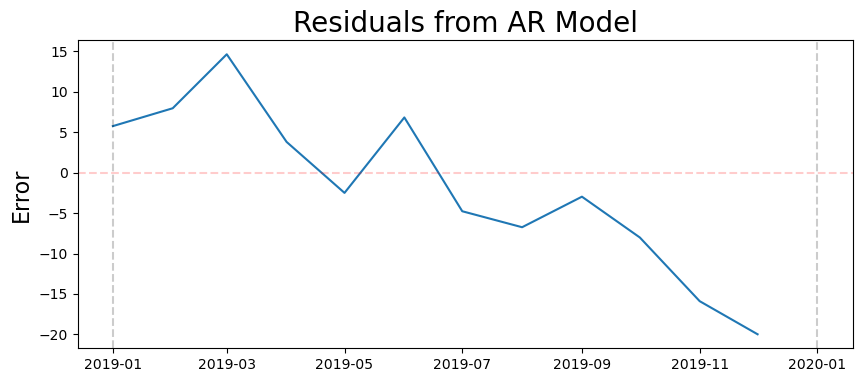

In [32]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

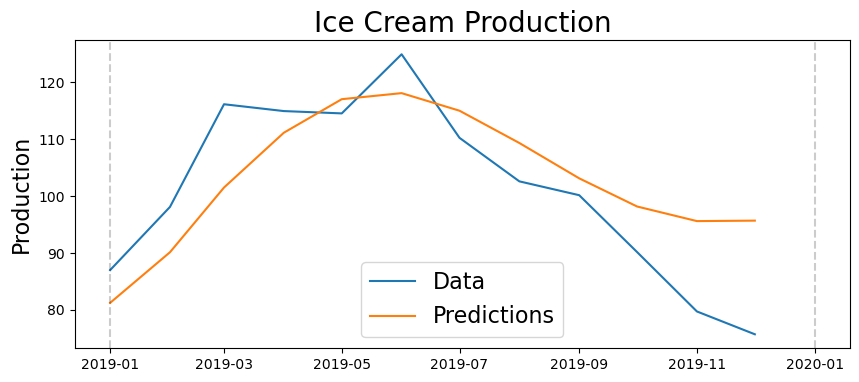

In [33]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production', fontsize=20)
plt.ylabel('Production', fontsize=16)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [34]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)), 4))

Mean Absolute Percent Error: 0.0895


In [35]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.88415874704018


AR07

In [36]:
# create the model with lag 3 and MA 0
model_ar07 = ARIMA(train_data, order=(7,0,0))

In [37]:
#fit the model
start = time()
model_ar07_fit = model_ar07.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 3.0170042514801025


In [38]:
#summary of the model
print(model_ar07_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(7, 0, 0)   Log Likelihood                -361.526
Date:                Sat, 04 Feb 2023   AIC                            741.051
Time:                        20:03:23   BIC                            765.191
Sample:                    01-01-2010   HQIC                           750.839
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.6216      1.339     77.406      0.000     100.998     106.245
ar.L1          0.9497      0.097      9.837      0.000       0.760       1.139
ar.L2         -0.0964      0.131     -0.735      0.4

In [39]:
#get the predictions and residuals
predictions = model_ar07_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

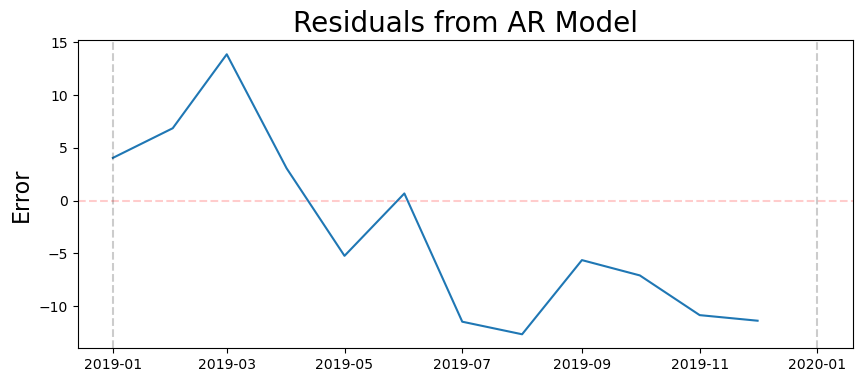

In [40]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

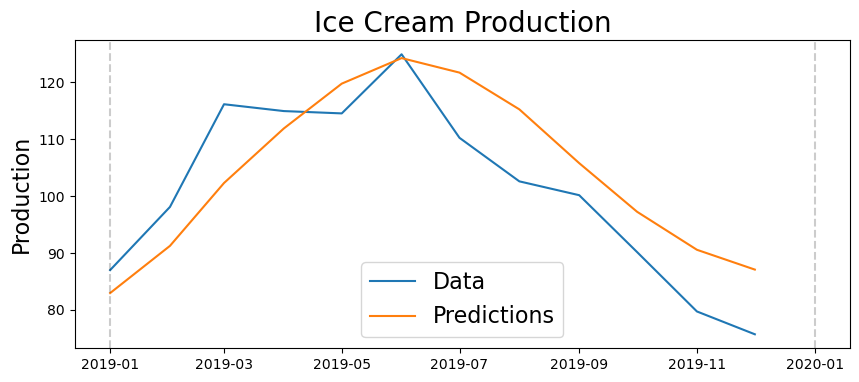

In [41]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production', fontsize=20)
plt.ylabel('Production', fontsize=16)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [42]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)), 4))

Mean Absolute Percent Error: 0.0802


In [43]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 8.725440398886988


Splitting the data 70-30

In [44]:
# get train and test sets
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = production_from_2010[:train_end]
test_data = production_from_2010[train_end + timedelta(days=1):test_end]

print(train_data)
print(test_data)

Date
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
                ...   
2016-08-01    121.3321
2016-09-01    108.0359
2016-10-01    101.3836
2016-11-01     86.6647
2016-12-01     81.2569
Freq: MS, Name: production, Length: 84, dtype: float64
Date
2017-01-01     94.2454
2017-02-01    112.3879
2017-03-01    119.6982
2017-04-01    123.2282
2017-05-01    116.0635
2017-06-01    123.0870
2017-07-01    116.2639
2017-08-01    113.1717
2017-09-01     97.9125
2017-10-01     90.4732
2017-11-01     77.4378
2017-12-01     75.8118
2018-01-01     83.4343
2018-02-01     99.4899
2018-03-01    107.3152
2018-04-01    112.4309
2018-05-01    110.3544
2018-06-01    124.5841
2018-07-01    117.2215
2018-08-01    112.6779
2018-09-01    103.3118
2018-10-01     92.1321
2018-11-01     82.4347
2018-12-01     76.7608
2019-01-01     86.9988
2019-02-01     98.1116
2019-03-01    116.1718
2019-04-01    114.9703
2019-05-01    114.5613
2019-06-01    1

In [45]:
# create the model with lag 3 and MA 0
model = ARIMA(train_data, order=(3,0,0))

In [46]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.7840292453765869


In [47]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -294.008
Date:                Sat, 04 Feb 2023   AIC                            598.015
Time:                        21:09:39   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5071      2.531     40.893      0.000      98.546     108.468
ar.L1          1.0488      0.116      9.046      0.000       0.822       1.276
ar.L2         -0.0532      0.204     -0.260      0.7

In [48]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [49]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

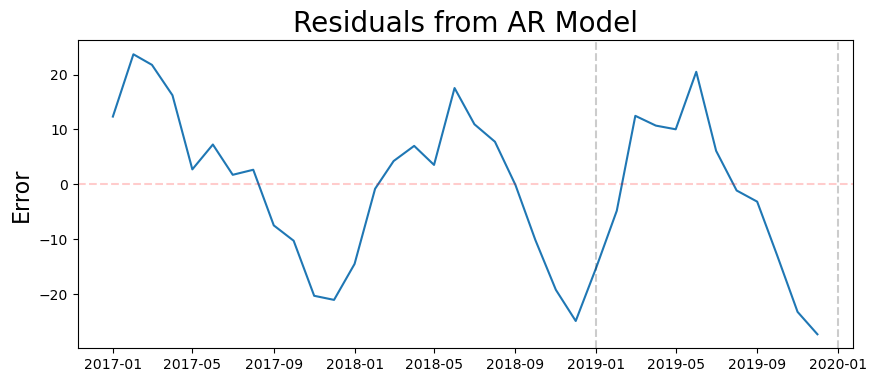

In [50]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

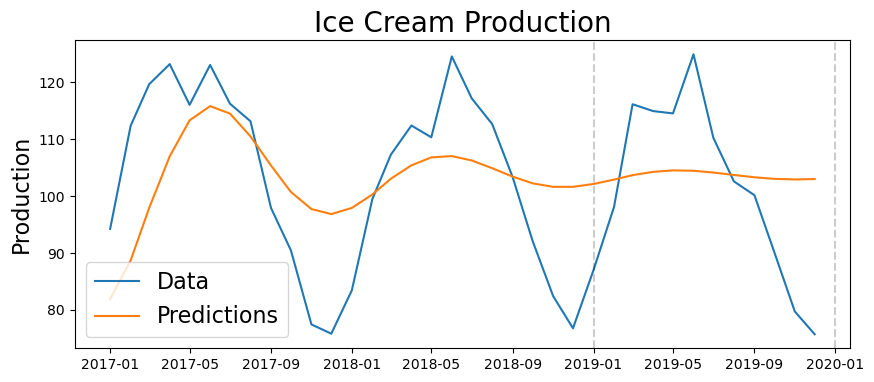

In [51]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production', fontsize=20)
plt.ylabel('Production', fontsize=16)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [52]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)), 4))

Mean Absolute Percent Error: 0.1211


In [53]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 13.890102330574297


Average all predictions

In [54]:
# create the model
predictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = production_from_2010[:end_date-timedelta(days=1)]
    model = ARIMA(train_data, order=(3,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]

C:\Users\equipo\AppData\Local\Temp\ipykernel_9912\3334352288.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()


In [60]:
residuals_rolling = test_data - predictions_rolling

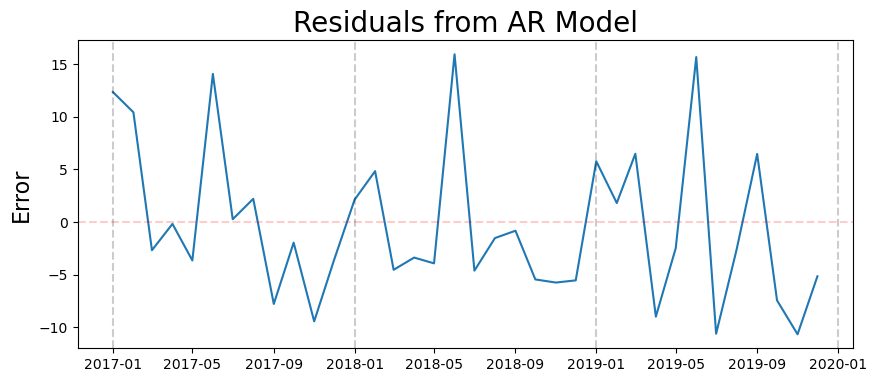

In [62]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

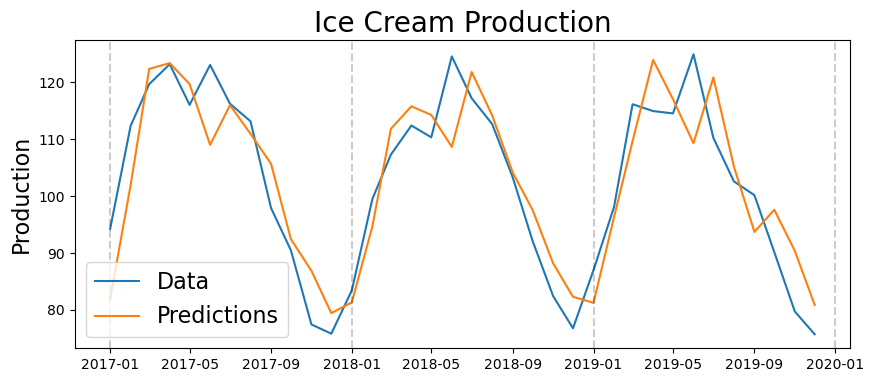

In [63]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production', fontsize=20)
plt.ylabel('Production', fontsize=16)

for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [64]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals_rolling/test_data)), 4))

Mean Absolute Percent Error: 0.0582


In [65]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_rolling**2)))

Root Mean Squared Error: 7.196513637203545
